<font size="2"> [github.com/jankoslavic/pypinm](http://github.com/jankoslavic/pypinm)</font>

<center>
<img width=300 src="./fig/ladisk.png">
<br>
<font size="7" color="f00e0e" face="garamond"><b>Interpolacija</b></font>
<br><br>
<font size="4">
[izr. prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)
</font>
<br><br>
<font size="2">September 2017</font>
</center>

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Uvod" data-toc-modified-id="Uvod-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Uvod</a></div><div class="lev1 toc-item"><a href="#Interpolacija-s-polinomom" data-toc-modified-id="Interpolacija-s-polinomom-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interpolacija s polinomom</a></div><div class="lev1 toc-item"><a href="#Polinomska-interpolacija---Lagrangeva-metoda" data-toc-modified-id="Polinomska-interpolacija---Lagrangeva-metoda-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Polinomska interpolacija - Lagrangeva metoda</a></div><div class="lev2 toc-item"><a href="#Ocena-napake" data-toc-modified-id="Ocena-napake-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ocena napake</a></div><div class="lev2 toc-item"><a href="#Primer-interpolacije" data-toc-modified-id="Primer-interpolacije-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Primer interpolacije</a></div><div class="lev2 toc-item"><a href="#Primer-ocene-napake-polinomske-interpolacije" data-toc-modified-id="Primer-ocene-napake-polinomske-interpolacije-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Primer ocene napake polinomske interpolacije</a></div><div class="lev2 toc-item"><a href="#Interpolacija-z-uporabo-scipy" data-toc-modified-id="Interpolacija-z-uporabo-scipy-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Interpolacija z uporabo <code>scipy</code></a></div><div class="lev1 toc-item"><a href="#Kubični-zlepki" data-toc-modified-id="Kubični-zlepki-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Kubični zlepki</a></div><div class="lev2 toc-item"><a href="#Naravni-kubični-zlepki" data-toc-modified-id="Naravni-kubični-zlepki-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Naravni kubični zlepki</a></div><div class="lev2 toc-item"><a href="#Numerična-implementacija" data-toc-modified-id="Numerična-implementacija-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Numerična implementacija</a></div><div class="lev2 toc-item"><a href="#Nekaj-komentarjev-modula-scipy.interpolate" data-toc-modified-id="Nekaj-komentarjev-modula-scipy.interpolate-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Nekaj komentarjev modula <code>scipy.interpolate</code></a></div><div class="lev2 toc-item"><a href="#Odvajanje,-integriranje-...-zlepkov" data-toc-modified-id="Odvajanje,-integriranje-...-zlepkov-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Odvajanje, integriranje ... zlepkov</a></div><div class="lev1 toc-item"><a href="#Nekaj-vprašanj-za-razmislek!" data-toc-modified-id="Nekaj-vprašanj-za-razmislek!-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Nekaj vprašanj za razmislek!</a></div><div class="lev2 toc-item"><a href="#Dodatno" data-toc-modified-id="Dodatno-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dodatno</a></div>

# Uvod

Pri **interpolaciji** izhajamo iz tabele (različnih) vrednosti $x_i, y_i$:

| $x_0$  | $x_1$  | $\dots$   | $x_{n-1}$ |
|:-:|:-:|:-:|:-:|:-:|
| $y_0$  | $y_1$  | $\dots$   | $y_{n-1}$ |

določiti pa želimo vmesne vrednosti. Če želimo določiti vrednosti zunaj tabele, govorimo o **ekstrapolaciji**.

V okviru **interpolacije** (angl. *interpolation*) točke povežemo tako, da predpostavimo neko funkcijo in dodamo pogoj, da funkcija *mora* potekati skozi podane točke. 

Pri **aproksimaciji** (angl. *approximation* ali tudi *curve fitting*) pa predpostavimo funkcijo, ki se čimbolje (glede na izbrani kriterij) prilega podatkom. 

Poglejmo si preprosti primer:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

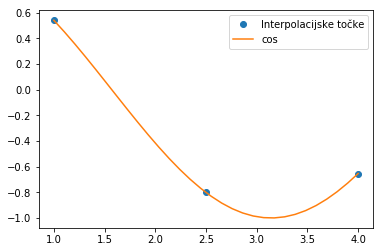

In [2]:
n = 3
x = np.linspace(1, 4, n)
f = np.cos # posplošimo interpolirano funkcijo (lahko spremenite v drugo funkcijo)
f_ime = f.__str__().split('\'')[1] # avtomatsko vzamemo ime funkcije
y = f(x)
x_g = np.linspace(np.min(x), np.max(x), 10*n)
y_g = f(x_g)
plt.plot(x, y, 'o', label='Interpolacijske točke');
plt.plot(x_g, y_g, label=f_ime);
plt.legend();

# Interpolacija s polinomom

Polinom stopnje $n-1$:
$$y = a_{n-1}\,x^{n-1} +a_{n-2}\,x^{n-2} +\cdots + a_{1}\,x + a_0.$$

je definiran z $n$ konstantami $a_i$. Da določimo $n$ konstant, potrebujemo $n$ (različnih) enačb. Za vsak par $x_i, y_i$ lahko torej zapišemo:
$$y_i = a_{n-1}\,x_i^{n-1} +a_{n-2}\,x_i^{n-2} +\cdots + a_{1}\,x_i + a_0.$$

Ker imamo podanih $n$ parov, lahko določimo $n$ neznanih konstant $a_i$, ki definirajo polinom stopnje $n-1$. Sistem $n$ linearnih enačb lahko zapišemo:
$$
\begin{bmatrix}
x_{0}^{n-1}&x_{0}^{n-2}&\dots&x_{0}^0\\
x_{1}^{n-1}&x_{1}^{n-2}&\dots&x_{1}^0\\
&&\vdots&&\\
x_{n-1}^{n-1}&x_{n-1}^{n-2}&\dots&x_{n-1}^0\\
\end{bmatrix}
\begin{pmatrix}
a_{n-1}\\
a_{n-2}\\
\vdots\\
a_{0}
\end{pmatrix}=
\begin{pmatrix}
y_{n-1}\\
y_{n-2}\\
\vdots\\
y_{0}
\end{pmatrix}
$$

Sistem linearnim enačb tipično zapišemo v obliki:
$$\mathbf{A}\,\mathbf{x}=\mathbf{b}$$
(Tukaj nas naj ne zmoti da je matrika koeficientov $\mathbf{A}$ definirana z vrednostmi $x$ in vektor konstant $\mathbf{b}$ z vrednostmi $y$ ter vektor neznank $\mathbf{x}$ z $a$. 
)

Definirajmo matriko koeficientov $\mathbf{A}$ in vektor konstant $\mathbf{b}$:

In [3]:
A = np.asarray([[_**p for p in reversed(range(len(x)))] for _ in x])
A  

array([[  1.  ,   1.  ,   1.  ],
       [  6.25,   2.5 ,   1.  ],
       [ 16.  ,   4.  ,   1.  ]])

In [4]:
b = y

Koeficienti $a_{n-1}, a_{n-2},\dots$ torej so:

In [5]:
resitev = np.linalg.solve(A, b)
resitev

array([ 0.33087687, -2.05236633,  2.26179176])

Pripravimo interpolacijski polinom kot python funkcijo:

In [6]:
def y_function(x, resitev):
    A = np.asarray([[_**p for p in reversed(range(len(resitev)))] for _ in x])
    return A.dot(resitev)

In izris interpolacijskega polinoma pri bolj gosti mreži točk:

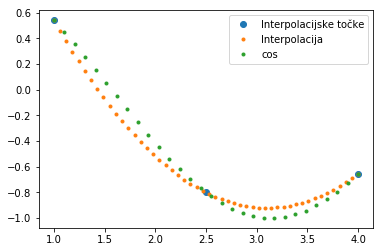

In [7]:
xint = np.linspace(np.min(x), np.max(x), 50)
yint = y_function(xint, resitev)
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(xint, yint, '.',label='Interpolacija')
plt.plot(x_g, y_g, '.',label=f_ime)
plt.legend();

Slabosti zgornjega postopka so:
 * število numeričnih operacij raste sorazmerno z $n^3$,
 * problem je lahko slabo pogojen (z večanjem stopnje polinoma slaba pogojenost naglo narašča):

In [8]:
np.linalg.cond(A)

71.302278703110801

Navodilo: vrnite se par vrstic nazaj in spremenite število interpolacijskih točk $n$ na višjo vrednost (npr. 10).

# Polinomska interpolacija - Lagrangeva metoda

*Lagrangevo* metodo ne zahteva reševanja sistema enačb in je iz stališča števila računskih operacij (narašča sorazmerno z $n^2$ ([vir](http://www.ams.org/journals/mcom/1970-24-109/S0025-5718-1970-0258240-X/S0025-5718-1970-0258240-X.pdf))) boljša od predhodne polinomske interpolacije (narašča sorazmerno z $n^3$), kjer smo reševali sistem linearnih enačb. Rešitev pa je seveda popolnoma enaka!

Lagrangev interpolacijski polinom stopnje $n-1$ je definirana kot:
$$P_{n-1}(x)=\sum_{i=0}^{n-1}y_i\,l_i(x),$$
kjer je $l_i$ definira Lagrangev polinom:
$$l_i(x)=\prod_{j=0, j\ne i}^{n-1} \frac{x-x_j}{x_i-x_j}.$$

Opazimo torej, da je rezultat Lagrangeve polinomske interpolacije $n$ polinomov stopnje $n$ (polinome definiramo na podlagi $n+1$ točk). Poglejmo si za interpolacijo za zgoraj prikazane $x$ in $y$ podatke.

Definirajmo najprej Lagrangeve polinome $l_i(x)=\prod_{j=0, j\ne i}^{n-1} \frac{x-x_j}{x_i-x_j}$:

In [9]:
def lagrange(x, x_int, i):
    """ Vrne vrednosti i-tega Lagrangevega polinoma
    
    x: neodvisna spremenljivka (skalar ali numerično polje)
    x_int: seznam interpolacijskih točk
    i: indeks polinoma
    """
    Lx = 1.0
    for j in range(len(x_int)):
        if j != i:
            Lx *= (x-x_int[j]) / (x_int[i]-x_int[j])
    return Lx

In [10]:
def slika(i=0):
    xint = np.linspace(np.min(x), np.max(x), 30)
    plt.plot(x, y, 'o', label='Interpolacijske točke')
    plt.plot(x_g, lagrange(x_g, x_int=x, i=i), '.',label=f'Lagrangev polinom i={i}');
    plt.plot(x_g, y_g, label=f_ime)
    plt.axhline(0, color='k', linewidth=0.3);
    for _ in x:
        plt.axvline(_, color='r', linewidth=0.5);
    plt.legend()
    plt.show()

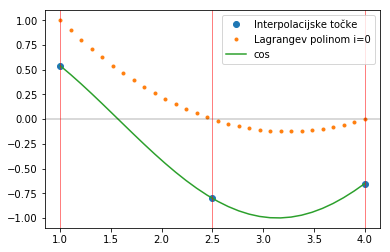

In [11]:
slika(i=0)

Opazimo, da ima Lagrangev polinom v $x_i$ vrednost 1, v ostalih točkah pa nič!

Če torej Lagrangev polinom za $i=0$ pomnožimo z $y_0$, bomo pri $x=x_0$ dobili pravo vrednost, v ostalih interpolacijskih točkah pa nič; implentirajmo torej Lagrangev interpolacijski polinom:
$$P_{n-1}(x)=\sum_{i=0}^{n-1}y_i\,l_i(x),$$


In [12]:
def lagrange_interpolacija(x, x_int, y_int):
    """ Vrne vrednosti Lagrangeve interpolacije
    
    x: neodvisna spremenljivka (skalar ali numerično polje)
    x_int: seznam interpolacijskih točk
    y_int: seznam interpolacijskih točk (odvisna spremenljivka)
    """
    y = 0.
    for i in range(len(x_int)):
        Lx = 1.0
        for j in range(len(x_int)):
            if j != i:
                Lx *= (x-x_int[j]) / (x_int[i]-x_int[j])
        y += y_int[i] * Lx
    return y

Pripravimo sliko:

In [13]:
def slika(i=0):
    xint = np.linspace(np.min(x), np.max(x), 30)
    plt.plot(x, y, 'o', label='Interpolacijske točke')
    plt.plot(x_g, lagrange(x_g, x_int=x, i=i), '.',label=f'Lagrangev polinom i={i}');
    plt.plot(x_g, lagrange_interpolacija(x_g, x_int=x, y_int=y), '.',label=f'Lagrangev int polinom');
    plt.plot(x_g, y_g, label=f_ime)
    plt.axhline(0, color='k', linewidth=0.3);
    for _ in x:
        plt.axvline(_, color='r', linewidth=0.5);
    plt.legend()
    plt.show()

In iz `ipywidgets` uvozimo ``interact``, ki je močno orodje za avtomatsko generiranje (preprostega) uporabniškega vmesnika znotraj `jupyter` okolja. Tukaj bomo uporabili relativno preprosto interakcijo s sliko; za pregled vseh zmožnosti pa radovednega bralca naslavljamo na [dokumentacijo](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html).

Uvoz funkcije ``interact``

In [14]:
from ipywidgets import interact

In [15]:
interact(slika, i=(0,len(x)-1,1));

Widget Javascript not detected.  It may not be installed or enabled properly.


Ugotovimo, da ima Lagrangev polimon $i$ samo pri $x_i$ vrednost $y_i$ v ostalih točkah $\ne i$ pa ima vrednosti nič. Očitno je, da z vsoto takih krivulj interpoliramo podatke.

Če ne interpoliramo polinomske funkcije, se interpolaciji večjega števila točk (kot npr. 5) izogibamo saj je lahko interpolacija relativno slaba, še posebej, če $\Delta x$ ni konstanten. 

## Ocena napake

Če je $f(x)$ funkcija, ki jo interpoliramo in je $P_{n-1}(x)$ Lagrangev interpolacijski polinom stopnje $n-1$, potem se lahko pokaže (glejte npr.: Burden, Faires, Burden: Numerical Analysis), da je napaka Lagrangeve interpolacije:
$$e=f(x)-P_{n-1}(x)=\frac{f^{(n)}(\xi)}{n!}\,(x-x_0)\,(x-x_1)\,\cdots\,(x-x_{n-1}),$$
kjer je $f^{(n)}$ neznani odvod funkcija stopnje $n$ stopnja interpolacijskega polinoma in $\xi$ neznana vrednost na interpoliranem področju $[x_0, x_{n-1}]$.

## Primer interpolacije

In [16]:
x = np.linspace(0, np.pi/2, 4)
y = np.sin(x)
#180*x/np.pi

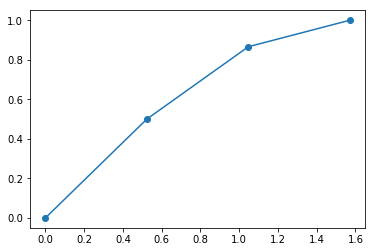

In [17]:
plt.plot(x, y, 'o-');

Linearna interpolacija (iščemo vrednosti pri $\sin(\pi/4)$)!

In [18]:
y_linearna = lagrange_interpolacija(x[-1]/2, x[1:3], y[1:3])
y_linearna

0.6830127018922193

Kvadratna:

In [19]:
y_kvadratna = lagrange_interpolacija(x[-1]/2, x[0:3], y[0:3])
y_kvadratna

0.69975952641916439

Kubična

In [20]:
y_kubična = lagrange_interpolacija(x[-1]/2, x, y)
y_kubična

0.70588928962874664

## Primer ocene napake polinomske interpolacije

Pri interpolaciji ponavadi funkcije $f(x)$ ne poznamo; v primeru zgoraj pa je definirana in lahko izračunamo točno napako:

In [21]:
print('Linearna: ', np.sin(x[-1]/2)-y_linearna)
print('Kvadratna:', np.sin(x[-1]/2)-y_kvadratna)
print('Kubična:  ', np.sin(x[-1]/2)-y_kubična)

Linearna:  0.0240940792943
Kvadratna: 0.00734725476738
Kubična:   0.0012174915578


*Napako bi pa lahko tudi ocenili s pomočjo formule:*
$$e=\frac{f^{(n)}(\xi)}{n!}\,(x-x_0)\,(x-x_1)\,\cdots\,(x-x_n)$$
Ker je v primeru linearne aproksimacije ($n=2$) drugi odvod sinusne funkcije ($f^{(n)}$) omejen z -1, velja:
$$e\le\frac{-1}{2!}\,(\pi/4-\pi/6)\,(\pi/4-\pi/3)=\frac{1}{2}\,\frac{\pi}{12}\,\frac{\pi}{12}=\frac{\pi^2}{288}=0,033$$

Poleg **Lagrangeve metode** bi si tukaj lahko pogledali še **Newtonovo metodo** interpolacije, ki je numerično učinkovitejša. Kot pa smo pokazali zgoraj, čez večje število točk taka interpolacija ni smiselna in zato bomo tukaj nadaljevali s t. i. **kubičnimi zlepki** (angl. *cubic spline*).

## Interpolacija z uporabo `scipy`

Poglejmo si interpolacijo v okviru paketa [scipy](https://docs.scipy.org/doc/scipy/reference/interpolate.html), tukaj bomo uporabili funkcijo za interpoliranje eno dimenzijske tabele [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d):

In [22]:
from scipy.interpolate import interp1d

``interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)``

`interp1d` zahteva najmanj dva parametra, to so interpolacijske točke `x` in `y`; privzeti parameter `kind='linear'` pomeni, da se odsekoma vzame linearno interpolacijo. `interp1d` vrne funkcijo `f`, ki jo kličemo z `f(x)` za izračun interpolirane vrednosti. Parameter `kind` je lahko npr. tudi: 'zero', 'slinear', 'quadratic' and 'cubic', takrat se uporabi interpolacijski zlepek (ang. *spline*) reda 0, 1, 2 oz 3. Zlepke si bomo pogledali v naslednjem poglavju.

Definirajmo tabelo podatkov:

In [23]:
x = np.linspace(1, 9, 8)
y = np.sin(x)

In [24]:
x

array([ 1.        ,  2.14285714,  3.28571429,  4.42857143,  5.57142857,
        6.71428571,  7.85714286,  9.        ])

In [25]:
y

array([ 0.84147098,  0.84078711, -0.14362322, -0.95999344, -0.65316501,
        0.41787078,  0.999995  ,  0.41211849])

In [26]:
len(x)

8

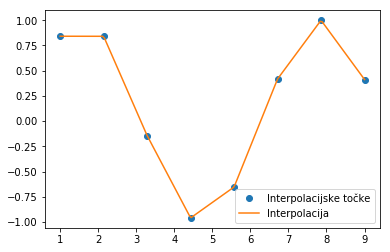

In [27]:
f = interp1d(x, y, kind='linear')
x_g = np.linspace(x[0], x[-1], 20*len(x)-1)
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(x_g, f(x_g), '-', label='Interpolacija')
plt.legend();

# Kubični zlepki

Preden gremo v teorijo zlepkov si poglejmo rezultat, ki ga dobimo s klicanjem funkcije `interp1d` s parametrom `kind='cubic'` (rezultat je kubični zlepek).

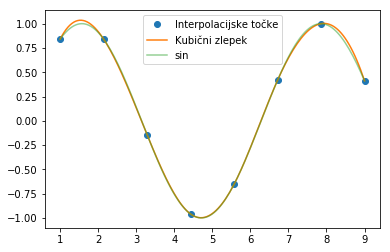

In [28]:
f = interp1d(x, y, kind='cubic')
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(x_g, f(x_g), '-', label='Kubični zlepek')
plt.plot(x_g, np.sin(x_g), label='sin', alpha=0.5)
plt.legend();

Kubični zlepki so pogosti način interpolacije. Ob predpostavki $x_0<x_1< \cdots <x_n$ gre za preprosto odsekovno interpolacijo s polinomom tretjega reda. 

Od točke $x_i$ do $x_{i+1}$ naj bo zlepek 
polinom:
$$f_{i,i+1}(x)= a_{i,3}\,x^3+a_{i,2}\,x^2+a_{i,1}\,x+a_{i,0},$$
pri čemer so neznane vrednosti konstant $a_{i,j}$. Če imamo na primer $n+1$ točk, potem je treba določiti $n$ polinomskih funkcij (za primer treh točk, potrebujemo dva polinoma: $f_{0,1}(x), f_{1,2}(x)$). 

Celotni zlepek čez $n$ točk je definiran z:
$$f(x) = \left\{
\begin{array}[rcl]%
f_{0,1}(x); && x\in[x_0, x_1)\\
f_{1,2}(x); && x\in[x_1, x_2)\\
&\vdots&\\
f_{n-1,n}(x); && x\in[x_{n-1}, x_n]
\end{array}
\right.
$$

Vsak polinom $f_{i,i+1}$ je definiran s 4 konstantami $a_{i,j}$; skupaj torej moramo izračunati $4n$ konstant $a_{i,j}$.

**Kako določimo konstante $a_{i,j}$?**

Za določitev $4n$ neznak potrebujemo $4n$ enačb. Poglejmo si, kako jih dobimo:
* $n+1$ enačbo dobimo iz interpolacijskega pogoja: $$y_i=f_{i,i+1}(x_i)$$
in za zadnjo točko $$y_n=f_{n-1,n}(x_n)$$
* $2(n-1)$ enačb dobimo iz pogoja $C^1$zveznosti: 
$$\lim_{x\rightarrow x_i^-}f(x)=\lim_{x\rightarrow x_i^+}f(x)$$
in
$$\lim_{x\rightarrow x_i^-}f'(x)=\lim_{x\rightarrow x_i^+}f'(x)$$

Manjka nam še $n+1$ enačb. 

Različni tipi zlepkov se ločijo po tem, kako te enačbe izberemo. V nadaljevanju si bomo pogledali *naravne kubične zlepke*.

## Naravni kubični zlepki

*Naravni kubični zlepki* temeljijo na ideji Eulerjevega nosilca:
$$E\,I\,\frac{\textrm{d}^4y}{\textrm{d}x^4}=q(x),$$
kjer je $E$ elastični modul, $I$ pa drugi moment preseka in $q(x)$ zunanja porazdeljena sila. Ker zunanje porazdeljene sile ni ($q(x)=0$), velja:
$$E\,I\,\frac{\textrm{d}^4y}{\textrm{d}x^4}=0.$$
Sledi, da lahko v vsaki točki tanek nosilec popišemo s polinomom tretje stopnje. 

Sedaj $n-1$ enačb določimo iz predpostavke, da je nosilec v znanih točkah členkasto vpet in se torej moment v členkih ne spremeni; to pomeni, da je 2. odvod v členkih zvezen (to imenujemo $C^2$ zveznost):

$$\lim_{x\rightarrow x_i^-}f''(x)=\lim_{x\rightarrow x_i^+}f''(x)$$

Preostali 2 neznanki pri naravnih kubičnih zlepkih določimo iz pogoja, da je moment na koncih enak nič (členkasto vpetje):

$$f''(x_{0})=0\qquad\textrm{in}\qquad f''(x_{n})=0$$

Izpeljava je natančneje prikazana v knjigi Kiusalaas J: Numerical Methods in Engineering with Python 3, 2013, stran 120 (glejte tudi J. Petrišič: Interpolacija, Fakulteta za strojništvo, 1999); podrobna izpeljava presega obseg te knjige. Tukaj si bomo pogledali samo končni rezultat, ki ga lahko izpeljemo ob zgornjih pogojih v primeru ekvidistantne delitve $h=x_{i+1}-x_i$ (takim zlepkom rečemo, da so *uniformni*). 

Če uporabimo zapis  $k_i = f''_{i,i+1}$ ($i=0,1,\dots,n-1$) lahko izpeljemo:

$$
f_{i,i+1}(x)=\frac{k_i}{6}\left(\frac{(x-x_{i+1})^3}{h}-(x-x_{i+1})\,h\right)
-\frac{k_{i+1}}{6}\left(\frac{(x-x_{i})^3}{h}-(x-x_{i})\,h\right)
+\frac{y_i\,(x-x_{i+1})-y_{i+1}\,(x-x_{i})}{h}
$$

kjer je $h=x_i-x_{i+1}$ in $k_i$ določimo iz sistema linearnih enačb:

$$k_{i-1} + 4 k_{i} + k_{i+1}  =  \frac{6}{h^2} \left(y_{i-1} -2 y_{i} +y_{i+1} \right).$$

Če na koncih ni momenta, velja:

$$k_0=k_n=0.$$

## Numerična implementacija

Najprej definirajmo funkcijo za izračun koeficientov $k_i$:

$$k_{i-1} + 4 k_{i} + k_{i+1}  =  \frac{6}{h^2} \left(y_{i-1} -2 y_{i} +y_{i+1} \right).$$

Konstante pred $k_i$ definirajo matriko koeficientov (tipično označimo z $\mathbf{A}$), $k_i$ so neznanke (tipično označimo z $\mathbf{x}$) in desna stran zgornje enačbe vektor konstant (tipično označimo z $\mathbf{b}$).

In [29]:
def kubicni_zlepki_koeficient(x, y):
    """ Vrne koeficiente kubičnih zlepkov `k`, matriko koeficientov `A` in konstant
    
    x in y predstavljata seznam znanih vrednosti; x mora biti ekvidistanten
    """
    n = len(x)
    A = np.zeros((n, n)) # pripravimo matriko koeficientov
    h = x[1]-x[0] # korak h
    for i in range(n):
        if i==0 or i==n-1:
            A[i,i] = 1. # k_0 in k_n sta nič zato tukaj damo 1
                       # pri vektorju konstant pa bomo dali 0, k_0 in k_n bosta torej 0
        else:
            A[i, i-1:i+2] = np.asarray([1., 4., 1.])
    b = np.zeros(n)
    b[1:-1] = (6/h**2)*(y[:-2] - 2*y[1:-1] + y[2:]) # desna stran zgornje enačbe
    k = np.linalg.solve(A,b)
    return k, A, b

Poglejmo si primer izračuna koeficientov:

In [30]:
x = np.asarray([1, 2, 3, 4, 5])
y = np.asarray([0, 1, 0, 1, 0])

k, A, b = kubicni_zlepki_koeficient(x, y)
print('Matrika koeficientov A lin. sistema:', A)
print('Vektor konstant b lin. sistema:     ', b)
print('Koeficienti k so:', k)

Matrika koeficientov A lin. sistema: [[ 1.  0.  0.  0.  0.]
 [ 1.  4.  1.  0.  0.]
 [ 0.  1.  4.  1.  0.]
 [ 0.  0.  1.  4.  1.]
 [ 0.  0.  0.  0.  1.]]
Vektor konstant b lin. sistema:      [  0. -12.  12. -12.   0.]
Koeficienti k so: [ 0.         -4.28571429  5.14285714 -4.28571429  0.        ]


Nato potrebujemo še kubični polinom v določenem intervalu; implementirajmo formulo:

$$
f_{i,i+1}(x)=\frac{k_i}{6}\left(\frac{(x-x_{i+1})^3}{h}-(x-x_{i+1})\,h\right)
-\frac{k_{i+1}}{6}\left(\frac{(x-x_{i})^3}{h}-(x-x_{i})\,h\right)
+\frac{y_i\,(x-x_{i+1})-y_{i+1}\,(x-x_{i})}{h}
$$

In [31]:
def kubicni_zlepki(k, x, y, x_najdi):
    """ Vrne kubicni zlepek pri delitvi `xint`
    
    k: koeficienti kubičnih zlepkov
    x in y: znane vrednosti, x mora biti ekvidistanten
    x_najdi: vrednosti kjer želimo izračunati kubični zlepek
    """  
    h = x[0] - x[1]
    i = int((x_najdi-x[0])//(-h))
    if i >= len(k)-1:
        i = len(k)-2
    out = ((x_najdi - x[i+1])**3/h - (x_najdi - x[i+1])*h)*k[i]/6.0 \
        - ((x_najdi - x[i])**3/h - (x_najdi - x[i])*h)*k[i+1]/6.0 \
        + (y[i]*(x_najdi - x[i+1]) \
        - y[i+1]*(x_najdi - x[i]))/h
    return out

In izračunamo interpolirane vrednosti:

In [32]:
xint = np.linspace(np.min(x), np.max(x), 50)
yint = np.asarray([kubicni_zlepki(k, x, y, _) for _ in xint])

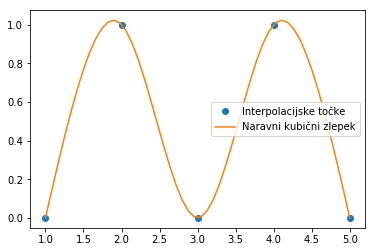

In [33]:
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(xint, yint, label='Naravni kubični zlepek')
plt.legend();

## Nekaj komentarjev modula ``scipy.interpolate``

SciPy ima implementiranih večje število različnih interpolacij ([glejte dokumentacijo](https://docs.scipy.org/doc/scipy/reference/interpolate.html). Iz stališča uporabe se bomo tukaj dotaknili  objektne implementacije [InterpolatedUnivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html) (starejši pristop temelji na funkcijskem programiranju, glejte: [scipy.interpolate.splrep](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html)):

In [34]:
from scipy.interpolate import InterpolatedUnivariateSpline

``InterpolatedUnivariateSpline(x, y, w=None, bbox=[None, None], k=3, ext=0, check_finite=False)``

Pri inicializaciji objekta `InterpolatedUnivariateSpline` moramo posredovati interpolacijske točke `x`in `y`, privzeti parameter `k=3` definiran red intepolacijskega zlepka (`1<=k<=5`). Pomemben opcijski parameter je tudi `w`, ki definira uteži posameznim interpolacijskim točkam (uporabimo, če želimo določenim področjem dati večji poudarek).

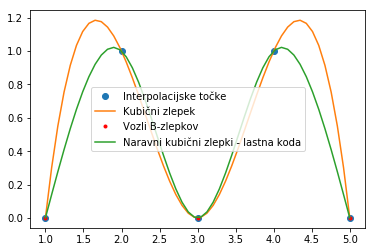

In [35]:
spl = InterpolatedUnivariateSpline(x, y, k=3) # poglejte opcije!
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(xint, spl(xint), label='Kubični zlepek');
plt.plot(spl.get_knots(), spl(spl.get_knots()), 'r.', label='Vozli B-zlepkov')
plt.plot(xint, yint, label='Naravni kubični zlepki - lastna koda');
plt.legend();

Ker gre za B-zlepke, je rezultat drugačen kakor smo ga izpelali z naravnimi kubičnimi zlepki. V nasprotju z naravnimi kubičnimi zlepki, ki imajo vozle (ang. *knots*) v interpolacijskih točkah, so vozli B-zlepkov prilagodijo podatkom. V konkretnem primeru so vozli v točkah:

In [36]:
spl.get_knots()

array([ 1.,  3.,  5.])

## Odvajanje, integriranje ... zlepkov

Zlepke lahko odvajamo in integriramo saj so polinomi. Objektom ``InterpolatedUnivariateSpline`` je tako že pripravljen za odvajanje, integriranje, iskanje korenov (ničel), vozlov... (glejte [dokumentacijo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html)).

Za prvi odvod na primer uporabimo metodo ``.derivative(1)``, ki vrne novi objekt spline krivulje (red je za 1 nižji):

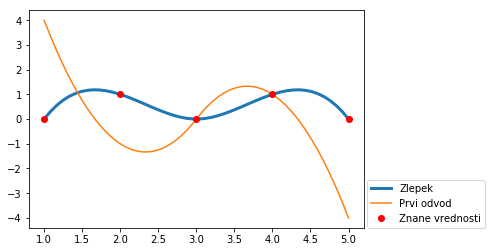

In [37]:
spl1 = spl.derivative(1)
#spl2 = spl.derivative(2)
#spl3 = spl.derivative(3)
plt.plot(xint, spl(xint), lw=3, label='Zlepek')
plt.plot(xint, spl1(xint), label='Prvi odvod')
#plt.plot(xint, spl2(xint), label='Drugi odvod')
#plt.plot(xint, spl3(xint), label='Tretji odvod')
plt.plot(x, y, 'ro', label='Znane vrednosti')
#plt.plot(spl.get_knots(), spl(spl.get_knots()), 'k.', label='Vozli B-zlepka')
plt.legend(loc=(1.01, 0));

# Nekaj vprašanj za razmislek!


1. Preštudirajte Lagrangevo polinomsko interpolacijo in pripravite funkcijo za Lagrangeve polinome. Pojasnite (z grafičnim prikazom) Lagrangeve polinome.
* Definirajte funkcijo za Lagrangevo polinomsko interpolacijo. Na primeru pojasnite kako deluje.
* Pojasnite teoretično ozadje naravnih kubičnih zlepkov.
* Naravne kubične zlepke smo izpeljali pod pogojem, da momenta na koncu ni; včasih želim drugačne pogoje na koncih (npr. znani naklon ali znani moment). Modificirajte na predavanjih predstavljeno kodo za primer, da je na koncih moment $\ne 0$ (predpostavite neko numerično vrednost).
* Podatke:
    ```python
    x = np.linspace(0, 10, 10)
    y = np.random.rand(10)-0.5
    ```
  interpolirajte z uporabo ``scipy.InterpolatedUnivariateSpline``. Podatke prikažite.
* Za zgoraj definirane podatke preučite pomoč in najdite vse ničle. Prikažite jih na predhodni sliki.
* Za zgoraj definirani zlepek izračunajte prvi odvod in ga prikažite.
* Za zgoraj definirani zlepek izračunajte določeni integral od začetka do konca.
* Za zgoraj definirane podatke z uporabo vgrajenih funkcij prikažite izračun linearnega in kvadratnega zlepka. Prikažite na sliki.
* Preučite pomoč za funkcijo ``scipy.interpolate.lagrange`` in k predhodni sliki dodajte Lagrangev interpolacijski polinom. Komentirajte rezultate.
* Preučite pomoč za funkcijo ``scipy.interpolate.interp1d`` in k predhodni sliki dodajte kvadratni zlepek.
* Preučite pomoč za funkcijo ``scipy.interpolate.BarycentricInterpolator`` in pojasnite ter prikažite njeno prednost.
* Preučite pomoč za funkcijo ``scipy.interpolate.KroghInterpolator`` in pojasnite njeno prednost.

## Dodatno

* 2D interpolacja: https://www.youtube.com/watch?v=_cJLVhdj0j4
* Strojno prevajanje: https://pypi.python.org/pypi/goslate)